In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


# **LIBRARY**

In [5]:
pip install squarify

In [6]:
import pandas as pd
import string

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [7]:
df = pd.read_csv("/content/gdrive/MyDrive/pizza/orders.csv")
df_odetails = pd.read_csv("/content/gdrive/MyDrive/pizza/order_details.csv")
df_piin4 = pd.read_csv("/content/gdrive/MyDrive/pizza/pizzas.csv")
df_pitype = pd.read_csv("/content/gdrive/MyDrive/pizza/pizza_types.csv", encoding = 'Windows-1252')

In [ ]:
df.head()

,order_id,date,time,customer_id,total_payment
0,1,2015-01-01,11:38:36,742,13.25
1,2,2015-01-01,11:57:40,5819,92.00
2,3,2015-01-01,12:12:28,5250,37.25
3,4,2015-01-01,12:16:31,6608,16.50
4,5,2015-01-01,12:21:30,1375,16.50


# **RFM ANALYSIS**

In [8]:
frequency = df.groupby('customer_id')['order_id'].count()
frequency = frequency.rename('frequency')

In [9]:
frequency.head()

,frequency
customer_id,
1,2
2,2
3,4
4,3
5,3


In [10]:
df['date_time'] = df['date'] + ' ' + df['time']
df['date_time'] = pd.to_datetime(df['date_time'],format = '%Y-%m-%d %H:%M:%S')

In [11]:
df['diff'] = max(df['date_time']) - df['date_time']
recency = df.groupby('customer_id')['diff'].min()
recency = recency.dt.days

In [12]:
recency.head()

,diff
customer_id,
1,132
2,153
3,26
4,12
5,177


In [13]:
monetary = df.groupby('customer_id')['total_payment'].sum()
monetary.head()

,total_payment
customer_id,
1,68.00
2,58.25
3,100.50
4,234.00
5,171.00


In [14]:
rfm = pd.merge(frequency, recency, on='customer_id', how = 'inner')
rfm = pd.merge(rfm, monetary, on='customer_id', how = 'inner')

In [19]:
rfm = rfm.rename(columns={'diff': 'recency', 'total_payment': 'monetary'})


In [21]:
rfm = rfm[['recency', 'frequency', 'monetary']]
rfm

,recency,frequency,monetary
customer_id,,,
1,132,2,68.00
2,153,2,58.25
3,26,4,100.50
4,12,3,234.00
5,177,3,171.00
...,...,...,...
6940,13,6,194.35
6941,77,3,165.25
6942,2,3,313.25


<ipython-input-22-94ad166ef7c4>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[col])


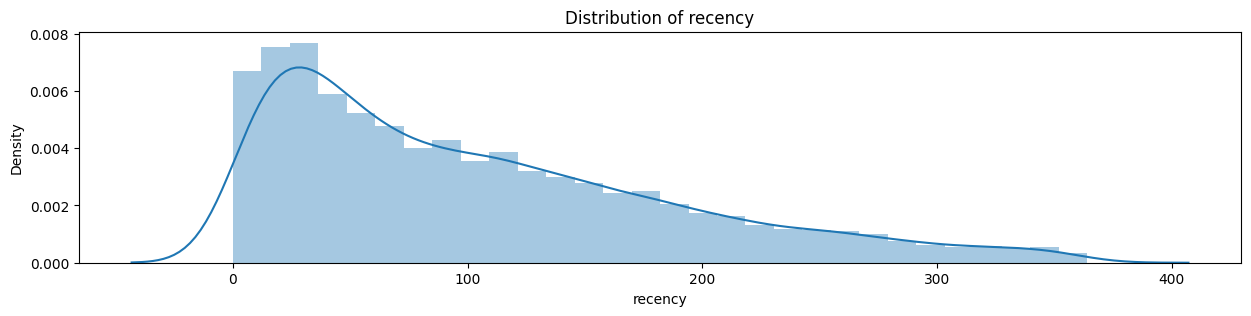

<ipython-input-22-94ad166ef7c4>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[col], bins=10)


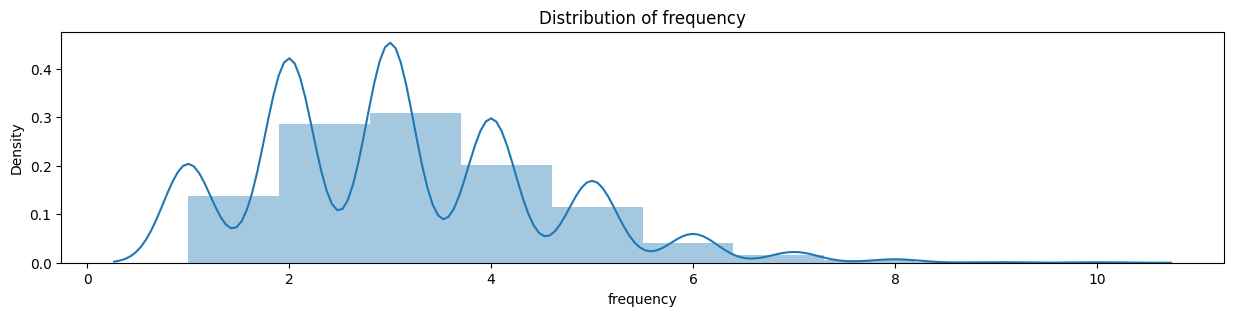

<ipython-input-22-94ad166ef7c4>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[col])


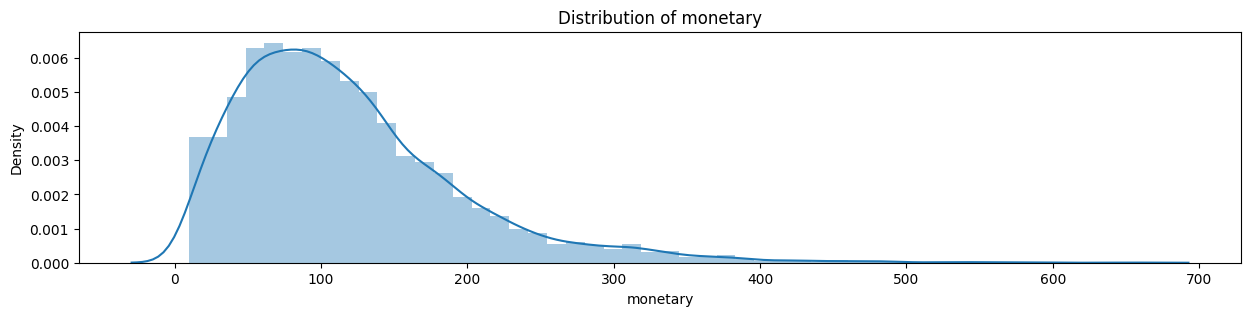

In [22]:
column_names = ['recency', 'frequency', 'monetary']

for col in column_names:
    fig, ax = plt.subplots(figsize=(15,3))
    if col == 'frequency':
        sns.distplot(rfm[col], bins=10)
    else:
        sns.distplot(rfm[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

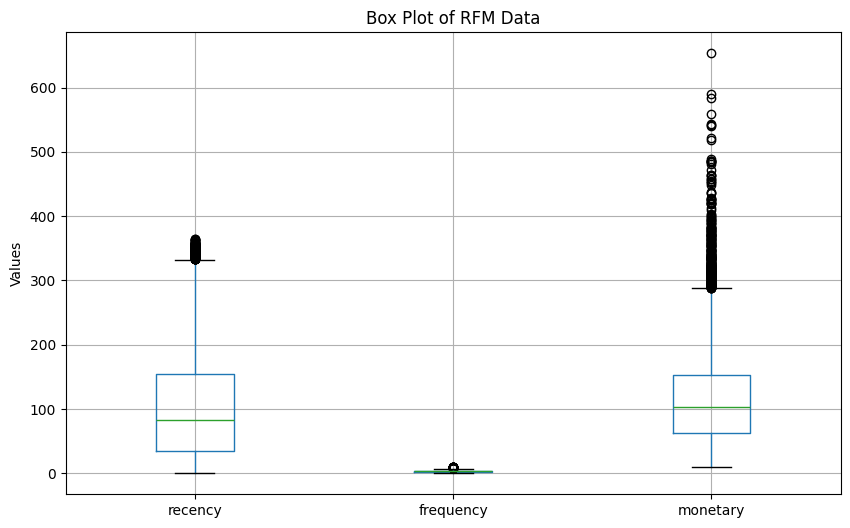

In [23]:
plt.figure(figsize=(10, 6))
rfm.boxplot(column=['recency', 'frequency', 'monetary'])
plt.title('Box Plot of RFM Data')
plt.ylabel('Values')
plt.show()

# **RFM - KMEANs**

In [25]:
scaler = StandardScaler()
rfm_scaler = rfm[['recency', 'frequency', 'monetary']]
rfm_scaler = scaler.fit_transform(rfm_scaler)
rfm_scaler = pd.DataFrame(rfm_scaler, columns=['recency', 'frequency', 'monetary'])

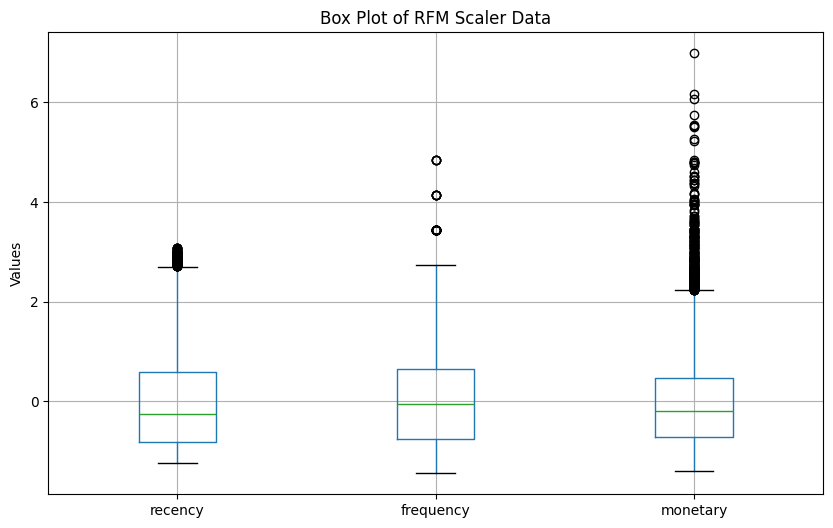

In [26]:
plt.figure(figsize=(10, 6))
rfm_scaler.boxplot(column=['recency', 'frequency', 'monetary'])
plt.title('Box Plot of RFM Scaler Data')
plt.ylabel('Values')
plt.show()

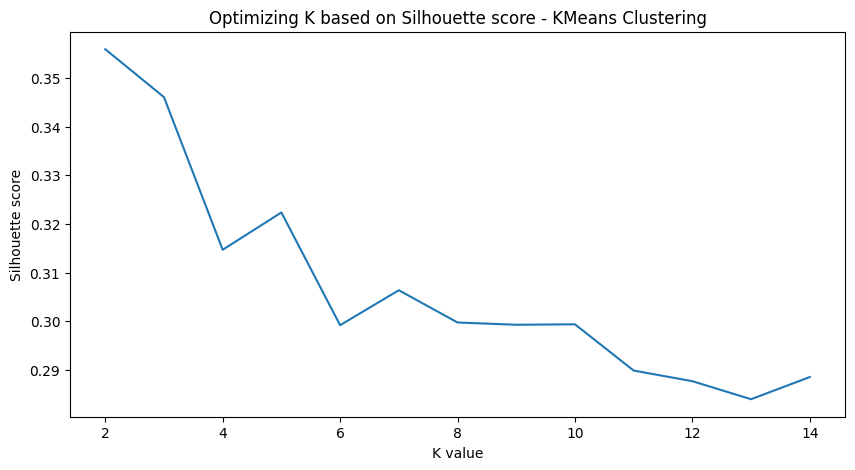

In [27]:
range_n_clusters = range(2,15)
silhouette_avg = []
for num_clusters in range_n_clusters:
  kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=33)
  kmeans.fit(rfm_scaler)
  cluster_labels = kmeans.labels_
  silhouette_avg.append(silhouette_score(rfm_scaler, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('K value')
plt.ylabel('Silhouette score')
plt.title('Optimizing K based on Silhouette score - KMeans Clustering')
plt.show()

**Select k = 3**



In [28]:
kmeans = KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans.fit(rfm_scaler)
kmeans_silhouette_score = silhouette_score(rfm_scaler, kmeans.labels_)
print("Silhoutte score: ", kmeans_silhouette_score)
rfm_scaler['kmeans_cluster'] = kmeans.labels_

Silhoutte score:  0.34571905317104096


In [29]:
rfm_scaler

,recency,frequency,monetary,kmeans_cluster
0,0.329018,-0.750421,-0.649186,0
1,0.577804,-0.750421,-0.776338,1
2,-0.926756,0.646235,-0.225345,0
3,-1.092613,-0.052093,1.515664,2
4,0.862130,-0.052093,0.694064,1
...,...,...,...,...
6939,-1.080766,2.042892,0.998578,2
6940,-0.322563,-0.052093,0.619077,0
6941,-1.211082,-0.052093,2.549184,2
6942,-0.002696,1.344564,0.589734,2


In [30]:
rfm_melted = pd.melt(rfm_scaler, id_vars=['kmeans_cluster'], value_vars=['recency', 'frequency', 'monetary'],
                    var_name='Metric', value_name='Value')

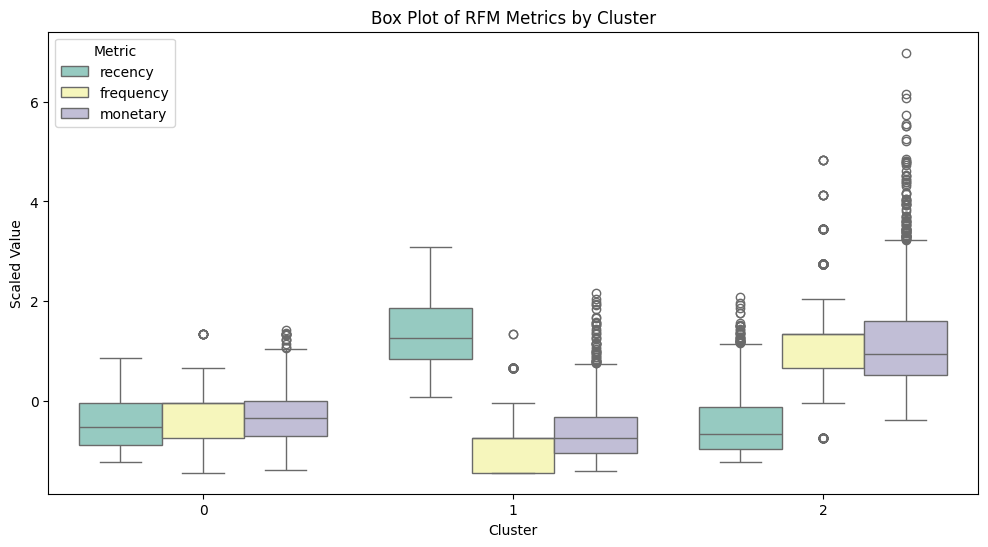

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='kmeans_cluster', y='Value', hue='Metric', data=rfm_melted, palette='Set3')
plt.title('Box Plot of RFM Metrics by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Scaled Value')
plt.show()

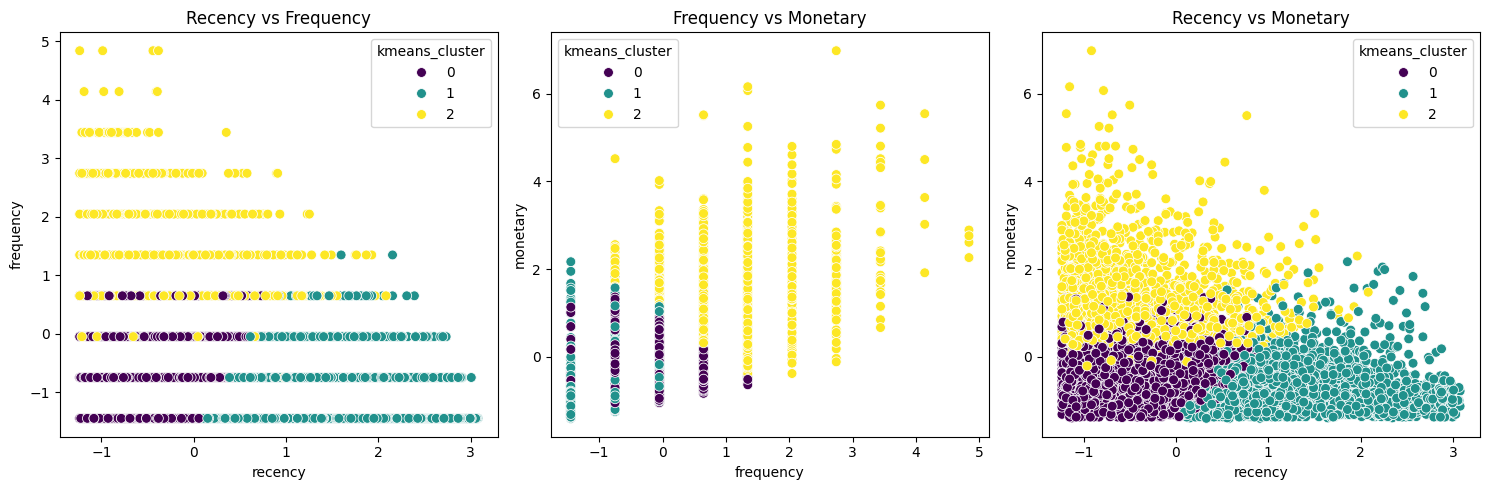

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='recency', y='frequency', hue='kmeans_cluster', data=rfm_scaler, palette='viridis', s=50)
plt.title('Recency vs Frequency')

plt.subplot(1, 3, 2)
sns.scatterplot(x='frequency', y='monetary', hue='kmeans_cluster', data=rfm_scaler, palette='viridis', s=50)
plt.title('Frequency vs Monetary')

plt.subplot(1, 3, 3)
sns.scatterplot(x='recency', y='monetary', hue='kmeans_cluster', data=rfm_scaler, palette='viridis', s=50)
plt.title('Recency vs Monetary')

plt.tight_layout()
plt.show()

In [33]:
fig = px.scatter_3d(rfm_scaler, x='recency', y='frequency', z='monetary',
                    color='kmeans_cluster', opacity=0.5,
                    labels={'recency': 'Recency', 'frequency': 'Frequency', 'monetary': 'Monetary'},
                    title='3D Visualization of RFM Clusters')

fig.show()

# **RFM - QUINTILES**

In [34]:
df_combi_rfm = pd.read_csv("/content/gdrive/MyDrive/pizza/125RFM.csv")


In [35]:
df_combi_rfm

,Unnamed: 0,Segment,RFM_Score
0,0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,1,Loyal Customers,"543, 444, 435, 355, 354, 345, 344, 335"
2,2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,3,Recent Customers,"512, 511, 422, 421, 412, 411, 311"
4,4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425, 4..."
5,5,Customers Needing Attention,"535, 534, 443, 434, 343, 334, 325, 324"
6,6,About To Sleep,"331, 321, 312, 221, 213"
7,7,At Risk,"255, 254, 245, 244, 253, 252, 243, 242, 235, 2..."
8,8,Can't Lose Them,"155, 154, 144, 214, 215, 115, 114, 113"
9,9,Hibernating,"332, 322, 231, 241, 251, 233, 232, 223, 222, 1..."


In [36]:
R_variable = range(5, 0, -1)
F_variable = range(1, 6)
M_variable = range(1, 6)

rfm['R_scores'] = pd.qcut(rfm['recency'], q=5, labels=R_variable)
rfm['F_scores'] = pd.qcut(rfm['frequency'].rank(method='first'), q=5, labels=F_variable)
rfm['M_scores'] = pd.qcut(rfm['monetary'], q=5, labels=M_variable)

In [37]:
rfm = rfm.reset_index()

In [38]:
rfm

,customer_id,recency,frequency,monetary,R_scores,F_scores,M_scores
0,1,132,2,68.00,2,1,2
1,2,153,2,58.25,2,1,2
2,3,26,4,100.50,5,4,3
3,4,12,3,234.00,5,2,5
4,5,177,3,171.00,1,2,5
...,...,...,...,...,...,...,...
6939,6940,13,6,194.35,5,5,5
6940,6941,77,3,165.25,3,4,4
6941,6942,2,3,313.25,5,4,5
6942,6943,104,5,163.00,3,5,4


In [39]:
rfm['RFM_Score'] = rfm['R_scores'].astype(str) + rfm['F_scores'].astype(str) + rfm['M_scores'].astype(str)
rfm['RFM_Score'] = rfm['RFM_Score'].astype(int)

In [40]:
rfm

,customer_id,recency,frequency,monetary,R_scores,F_scores,M_scores,RFM_Score
0,1,132,2,68.00,2,1,2,212
1,2,153,2,58.25,2,1,2,212
2,3,26,4,100.50,5,4,3,543
3,4,12,3,234.00,5,2,5,525
4,5,177,3,171.00,1,2,5,125
...,...,...,...,...,...,...,...,...
6939,6940,13,6,194.35,5,5,5,555
6940,6941,77,3,165.25,3,4,4,344
6941,6942,2,3,313.25,5,4,5,545
6942,6943,104,5,163.00,3,5,4,354


In [41]:
df_combi_rfm['RFM_Score'] = df_combi_rfm['RFM_Score'].str.split(',')

df_combi_rfm = df_combi_rfm.explode('RFM_Score')

df_combi_rfm['RFM_Score'] = df_combi_rfm['RFM_Score'].astype(int)

df_combi_rfm.sort_values(by='RFM_Score')
df_combi_rfm.head(10)

,Unnamed: 0,Segment,RFM_Score
0,0,Champions,555
0,0,Champions,554
0,0,Champions,544
0,0,Champions,545
0,0,Champions,454
0,0,Champions,455
0,0,Champions,445
1,1,Loyal Customers,543
1,1,Loyal Customers,444
1,1,Loyal Customers,435


In [42]:
rfm_quin = pd.merge(rfm, df_combi_rfm, on='RFM_Score', how='inner')
rfm_quin.head()

,customer_id,recency,frequency,monetary,R_scores,F_scores,M_scores,RFM_Score,Unnamed: 0,Segment
0,1,132,2,68.00,2,1,2,212,9,Hibernating
1,2,153,2,58.25,2,1,2,212,9,Hibernating
2,3,26,4,100.50,5,4,3,543,1,Loyal Customers
3,4,12,3,234.00,5,2,5,525,4,Promising
4,5,177,3,171.00,1,2,5,125,7,At Risk


<ipython-input-43-796e6c1df2f0>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




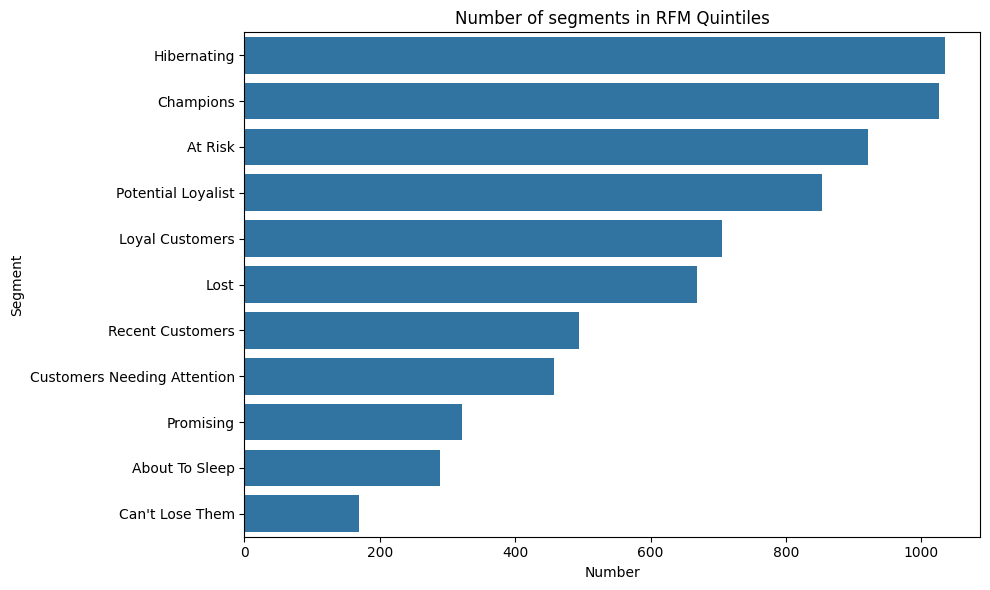

In [43]:
segment_counts = rfm_quin['Segment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(y=segment_counts.index, x=segment_counts.values, palette=['#1f77b4'] * len(segment_counts), orient='h')
plt.title('Number of segments in RFM Quintiles')
plt.ylabel('Segment')
plt.xlabel('Number')
plt.tight_layout()
plt.show()

In [45]:
segment_counts = rfm_quin.groupby('Segment')['customer_id'].count().reset_index()
segment_counts.rename(columns={'customer_id': 'customer_count'}, inplace=True)

total_customers = segment_counts['customer_count'].sum()
segment_counts['count_share'] = (segment_counts['customer_count'] / total_customers)*100

segment_counts

,Segment,customer_count,count_share
0,About To Sleep,289,4.161866
1,At Risk,921,13.263249
2,Can't Lose Them,170,2.448157
3,Champions,1026,14.775346
4,Customers Needing Attention,457,6.581221
5,Hibernating,1035,14.904954
6,Lost,669,9.634217
7,Loyal Customers,706,10.167051
8,Potential Loyalist,854,12.298387
9,Promising,322,4.637097


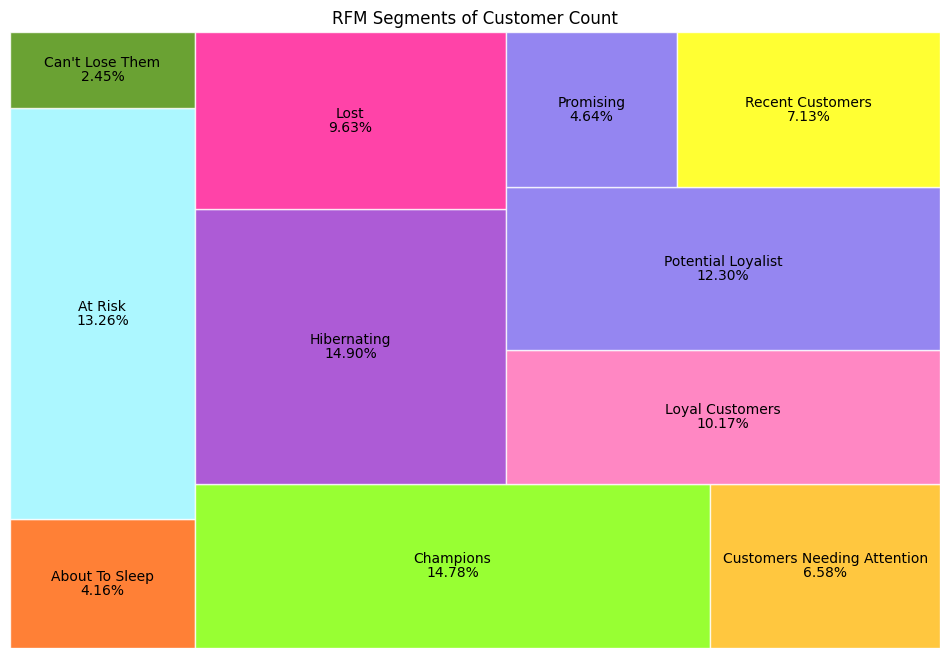

In [46]:
colors = ['#FF6103','#98F5FF','#458B00','#7FFF00','#FFB90F','#9932CC','#FF1493','#FF69B4','#7B68EE','#7A67EE','#FFFF00']

fig, ax = plt.subplots(1, figsize = (12,8))

squarify.plot(sizes = segment_counts['customer_count'],
              label = segment_counts['Segment'],
              value = [f'{x:.2f}%' for x in segment_counts['count_share']],
              alpha = .8,
              color = colors,
              bar_kwargs = dict(linewidth=1, edgecolor="white")
             )
plt.title('RFM Segments of Customer Count', fontsize=12)
plt.axis('off')
plt.show()

In [47]:
scaler = StandardScaler()

rfm_quin_scaler= rfm_quin[['recency', 'frequency', 'monetary']]

rfm_quin_scaler = scaler.fit_transform(rfm_quin_scaler)

rfm_quin_scaler = pd.DataFrame(rfm_quin_scaler, columns=['recency', 'frequency', 'monetary'])

rfm_quin_scaler = pd.concat([rfm_quin[['Segment']], rfm_quin_scaler], axis=1)
rfm_quin_scaler['customer_id'] = rfm_quin['customer_id']
rfm_quin_scaler.head()


,Segment,recency,frequency,monetary,customer_id
0,Hibernating,0.329018,-0.750421,-0.649186,1
1,Hibernating,0.577804,-0.750421,-0.776338,2
2,Loyal Customers,-0.926756,0.646235,-0.225345,3
3,Promising,-1.092613,-0.052093,1.515664,4
4,At Risk,0.862130,-0.052093,0.694064,5


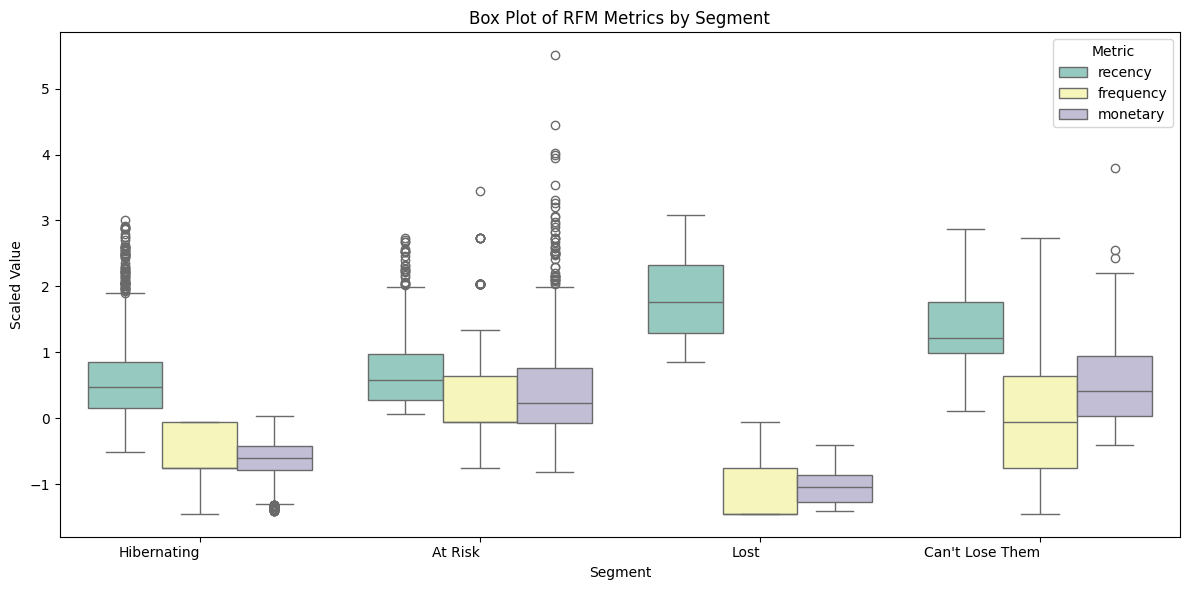

In [48]:
filtered_rfm_quin_scaler = rfm_quin_scaler[rfm_quin_scaler['Segment'].isin(['Hibernating', "Can't Lose Them", 'At Risk', 'Lost'])]

rfm_melted_filtered = pd.melt(filtered_rfm_quin_scaler, id_vars=['Segment'], value_vars=['recency', 'frequency', 'monetary'], var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Segment', y='Value', hue='Metric', data=rfm_melted_filtered, palette='Set3')
plt.title('Box Plot of RFM Metrics by Segment')
plt.xlabel('Segment')
plt.ylabel('Scaled Value')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

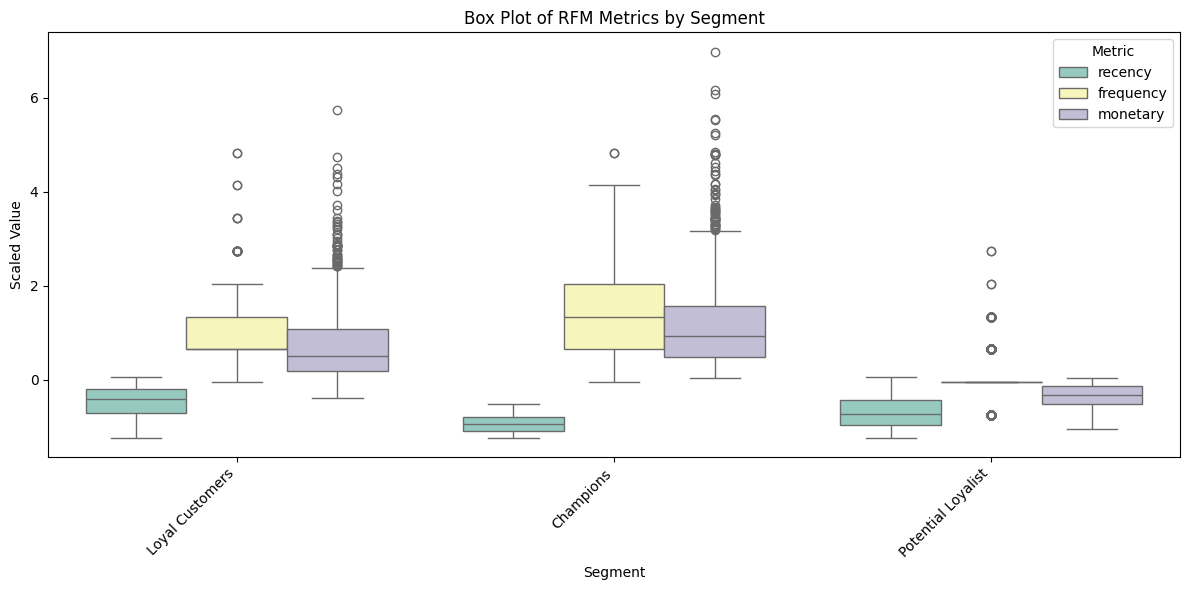

In [49]:
filtered_rfm_quin_scaler = rfm_quin_scaler[rfm_quin_scaler['Segment'].isin(['Champions',  'Potential Loyalist', 'Loyal Customers'])]

rfm_melted_filtered = pd.melt(filtered_rfm_quin_scaler, id_vars=['Segment'], value_vars=['recency', 'frequency', 'monetary'], var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Segment', y='Value', hue='Metric', data=rfm_melted_filtered, palette='Set3')
plt.title('Box Plot of RFM Metrics by Segment')
plt.xlabel('Segment')
plt.ylabel('Scaled Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

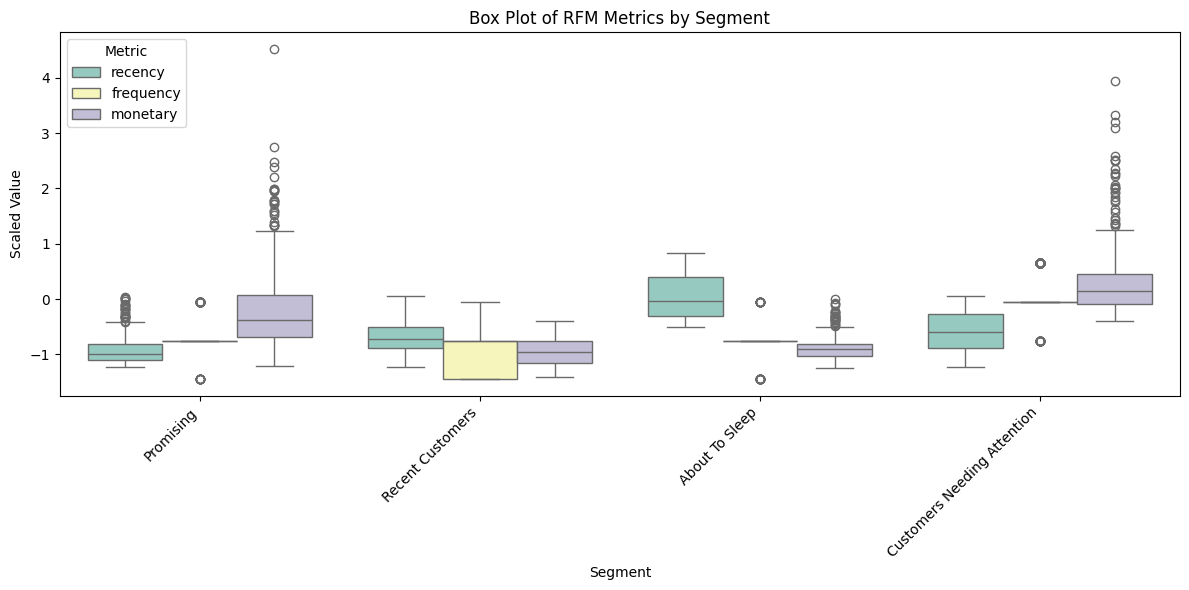

In [52]:
filtered_rfm_quin_scaler = rfm_quin_scaler[rfm_quin_scaler['Segment'].isin(['Recent Customers', 'Customers Needing Attention', 'Promising', 'About To Sleep'])]

rfm_melted_filtered = pd.melt(filtered_rfm_quin_scaler, id_vars=['Segment'], value_vars=['recency', 'frequency', 'monetary'], var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Segment', y='Value', hue='Metric', data=rfm_melted_filtered, palette='Set3')
plt.title('Box Plot of RFM Metrics by Segment')
plt.xlabel('Segment')
plt.ylabel('Scaled Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()